# Special Session: Noise Characterization and Error Mitigation in Near-Term Quanutm Computers

* Christopher J. Wood (cjwood@us.ibm.com)
* IBM Quantum, T. J. Watson Research Center, Yorktown Heights, USA

This notebook contains the accompanying code to the ICCD 2020 special session proceeding *Noise Characterization and Error Mitigation in Near-Term Quantum Computers*.

## 1. Interleaved Randomized Benchmarking

This notebook demonstrates performing interleaved randomized benchmarking (RB) of a a 2-qubit Controlled-NOT (CX) gate.

In [1]:
# Qiskit Module
import qiskit
import qiskit.quantum_info as qi
import qiskit.ignis.verification.randomized_benchmarking as rb

# Noisy Simulation
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel

# File utilities for saving and loading JSON data
from file_utils import save_to_json, load_properties, load_result

# Other
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt

### Interleaved RB Circuit Generation

First we generate the random input circuits for performing interleaved RB using the `randomized_benchmarking` moduel of *qiskit-ignis*.

In [2]:
# IRB Params
clifford_seqs = np.arange(1, 200, 20)  # sequence lengths
num_seeds = 20  # Number of random sequences per length
rng_seed = 772

# Interleaved Gate (CX)
cx = qiskit.circuit.library.CXGate()
cx = qiskit.QuantumCircuit(2).compose(cx, [0, 1])

# Generate RB circuits
rb_circs, xdata, irb_circs = rb.randomized_benchmarking_seq(
    num_seeds, clifford_seqs,
    rb_pattern=[[0, 1]],
    interleaved_elem=[cx],
    rand_seed=rng_seed)

### Run Experiment

Next execute the circuits on the IBM Quantum Boeblingen backend. You may change this to run on any IBM Quantum backend you have access to.

In [3]:
use_saved_data = True
file_properties = 'data/properties_irb_v1.json'
file_result_rb = 'data/results_rb_v1.json'
file_result_irb = 'data/results_irb_v1.json'

if use_saved_data:

    # Load saved result data from file
    results_rb_backend = load_result(file_result_rb)
    results_irb_backend = load_result(file_result_irb)

    # Load saved properties from file
    properties = load_properties(file_properties)

else:

    # Load IBMQ Account data
    from qiskit import IBMQ
    IBMQ.load_account()

    # Get backend for experiment
    provider = IBMQ.get_provider(project='ignis')
    backend = provider.get_backend('ibmq_boeblingen')

    # Run on backend
    shots = 1024
    jobs_rb = []
    jobs_irb = []
    for i in range(num_seeds):
        rb_job = qiskit.execute(rb_circs[i], backend, shots=shots)
        jobs_rb.append(rb_job)

        irb_job = qiskit.execute(irb_circs[i], backend, shots=shots)
        jobs_irb.append(irb_job)
    print('RB Jobs: {}'.format([job.job_id() for job in jobs_rb]))
    print('IRB Jobs: {}'.format([job.job_id() for job in jobs_irb]))

    # Save a copy of the backend properties to file
    properties = backend.properties()
    save_to_json(properties, file_properties)
          
    # Retrieve RB results (this may take a while depending on the queue)
    results_rb_backend = [job.result() for job in jobs_rb]
    results_irb_backend = [job.result() for job in jobs_irb]

    # Save a copy of the result data to file
    save_to_json(results_rb_backend, file_result_rb)
    save_to_json(results_irb_backend, file_result_irb)

### Run Simulation

Next we run the interleaved RB experiment using the Qiskit Aer simulator with the basic device noise model based on the backend used to run the experiment

In [4]:
# Simulator backend
simulator = QasmSimulator()
shots = 1024
seed_simulator = 12345

# Noise Model
noise_model = NoiseModel.from_backend(properties, warnings=False)

results_rb_sim = []
results_irb_sim = []
for i in range(num_seeds):

    # Execute RB circuits
    rb_result = qiskit.execute(rb_circs[i], simulator,
                               shots=shots,
                               seed_simulator=seed_simulator,
                               basis_gates=noise_model.basis_gates,
                               noise_model=noise_model).result()
    results_rb_sim.append(rb_result)
    
    # Execute IRB circuits
    irb_result = qiskit.execute(irb_circs[i], simulator,
                                shots=shots,
                                seed_simulator=seed_simulator,
                                basis_gates=noise_model.basis_gates,
                                noise_model=noise_model).result()
    results_irb_sim.append(irb_result)

## Fitting Results

Next we perform the analysis of the experiment results to fit the exponential decay curves and compute the average gate fidelity of the gate set and interleaved gate. This is done using the `InterleavedRBFitter` class.

### Fitting Experiment Data

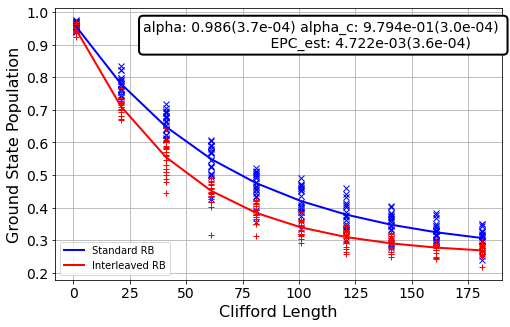

In [5]:
# Load data into fitter
rbfit_backend = rb.fitters.InterleavedRBFitter(
    results_rb_backend[0], results_irb_sim[0], xdata, [[0, 1]])
for i in range(1, num_seeds):
    rbfit_backend.add_data(results_rb_backend[i], results_irb_backend[i])
    
# Perform fit
fit_result_backend = rbfit_backend.fit_int[0]

# Generator fit plot
fig = plt.figure(figsize=(8, 5)) 
ax = fig.add_subplot(111)
rbfit_backend.plot_rb_data(ax=ax)
fig.savefig('figures/irb_cx_gate.png', dpi=150)

### Fitting Simulated Data

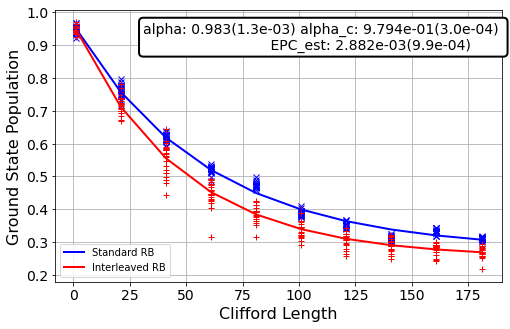

In [6]:
# Load data into fitter
rbfit_sim = rb.fitters.InterleavedRBFitter(
    results_rb_sim[0], results_irb_sim[0], xdata, [[0, 1]])
for i in range(1, num_seeds):
    rbfit_sim.add_data(results_rb_sim[i], results_irb_backend[i])

# Perform fit
fit_result_sim = rbfit_sim.fit_int[0]

# Generator fit plot
fig = plt.figure(figsize=(8, 5)) 
ax = fig.add_subplot(111)
rbfit_sim.plot_rb_data(ax=ax)

## Interleaved Gate Fidelity

From the fit parameters we can extract the estimated average gate fidelity and error of the interleaved gate

In [7]:
F_backend = 1 - fit_result_backend['epc_est']
F_err_backend = fit_result_backend['epc_est_err']

F_sim = 1 - fit_result_sim['epc_est']
F_err_sim = fit_result_sim['epc_est_err'] 

print('Average Gate Fidelity\n')
print('F({}) = {:.4f} \u00B1 {:.4f}'.format(
    properties.backend_name, F_backend, F_err_backend))
print('F(simulator) = {:.4f} \u00B1 {:.4f}'.format(
    F_sim, F_err_sim))

Average Gate Fidelity

F(ibmq_boeblingen) = 0.9953 ± 0.0004
F(simulator) = 0.9971 ± 0.0010


#### Backend reported gate fidelity

We can compare the above to the reported average gate fidelity of the CX gate in the backend properties

In [8]:
F_properties = 1 - properties.gate_error('cx', [0, 1])
print('F({}, properties) = {:.3f}'.format(properties.backend_name, F_properties))

F(ibmq_boeblingen, properties) = 0.993


In [9]:
import qiskit.tools.jupyter
%qiskit_version_table